# Interactively run miniscope workflow

+ This notebook walks you through the steps in detail to run the `workflow-miniscope`.  

+ The workflow requires the data acquired from the UCLA Miniscope and Miniscope-DAQ software and processing with CaImAn.

+ If you haven't configured the paths, refer to [01-configure](01-configure.ipynb).

+ To overview the schema structures, refer to [02-workflow-structure](02-workflow-structure.ipynb).

+ If you need a more automatic approach to run the workflow, refer to [04-automate](04-automate-optional.ipynb).

Let's change the directory to the package root directory to load the local configuration (`dj_local_conf.json`).

In [19]:
import os
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
import numpy as np

## `Pipeline.py`

+ This script `activates` the DataJoint `Elements` and declares other required tables.

In [20]:
import datajoint as dj
from workflow_miniscope.pipeline import subject, session, miniscope, Equipment, \
                                        AnatomicalLocation

## Schema diagrams

+ The following outputs are the diagrams of the schemas comprising this workflow.

+ Please refer back to these diagrams to visualize the relationships of different tables.

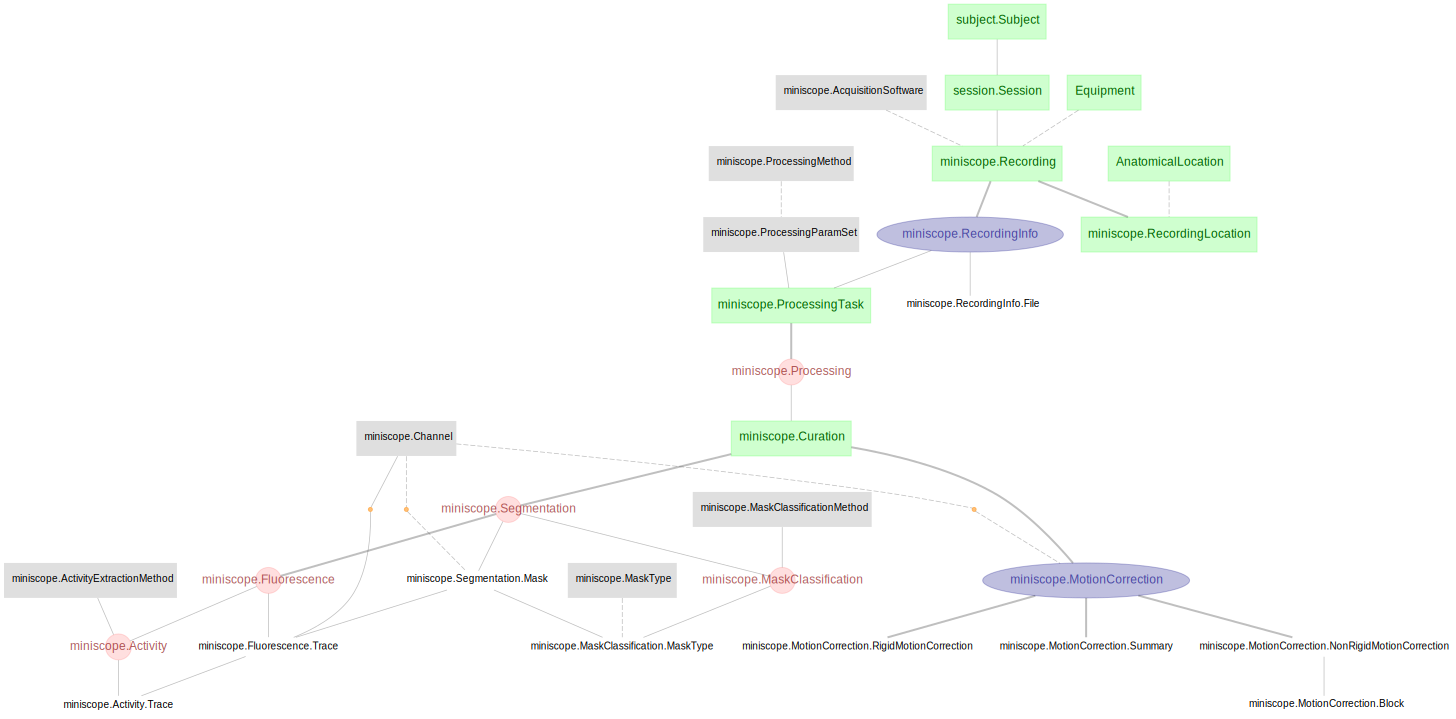

In [21]:
dj.Diagram(subject.Subject) + dj.Diagram(session.Session) + \
     dj.Diagram(AnatomicalLocation) + dj.Diagram(Equipment) +  dj.Diagram(miniscope) 

## Insert an entry into `subject.Subject`

In [22]:
subject.Subject.heading

# Animal Subject
subject              : varchar(8)                   # 
---
sex                  : enum('M','F','U')            # 
subject_birth_date   : date                         # 
subject_description="" : varchar(1024)                # 

In [23]:
subject.Subject.insert1(dict(subject='subject1', 
                             sex='F', 
                             subject_birth_date='2020-01-01', 
                             subject_description='UCLA Miniscope acquisition'))

DuplicateError: ("Duplicate entry 'subject1' for key 'subject.PRIMARY'", 'To ignore duplicate entries in insert, set skip_duplicates=True')

## Insert an entry into `lab.Equipment`

In [24]:
Equipment.insert1(dict(equipment='UCLA Miniscope',
                       modality='Miniscope',
                       description='V4, >1mm field of view, 1mm working distance'))

DuplicateError: ("Duplicate entry 'UCLA Miniscope' for key 'equipment.PRIMARY'", 'To ignore duplicate entries in insert, set skip_duplicates=True')

## Insert an entry into `session.Session`

In [ ]:
session.Session.describe();

In [ ]:
session.Session.heading

In [25]:
session_key = dict(subject='subject1', 
                   session_datetime='2021-01-01 00:00:01')

In [26]:
session.Session.insert1(session_key)

DuplicateError: ("Duplicate entry 'subject1-2021-01-01 00:00:01' for key 'session.PRIMARY'", 'To ignore duplicate entries in insert, set skip_duplicates=True')

In [ ]:
session.Session()

## Insert an entry into `session.SessionDirectory`

+ The `session_dir` is the relative path to the `miniscope_root_data_dir` for the given session, in POSIX format with `/`.

+ Instead of a relative path, `session_dir` could be an absolute path but it is not recommended as the absolute path would have to match the `miniscope_root_data_dir` in `dj_local_conf.json`.

In [ ]:
session.SessionDirectory.describe();

In [ ]:
session.SessionDirectory.heading

In [27]:
session.SessionDirectory.insert1(dict(**session_key, 
                                      session_dir='subject1/session1'))

DuplicateError: ("Duplicate entry 'subject1-2021-01-01 00:00:01' for key 'session_directory.PRIMARY'", 'To ignore duplicate entries in insert, set skip_duplicates=True')

In [28]:
session.SessionDirectory()

subject,session_datetime,session_dir Path to the data directory for a session
subject1,2021-01-01 00:00:01,subject1/session1
subject1,2022-04-27 12:13:01,subject1/session1
subject6,2021-06-01 13:33:33,from_top_tracking/
subject6,2021-06-02 14:04:22,from_top_tracking/


## Insert an entry into `miniscope.Recording`

In [29]:
miniscope.Recording.heading

# 
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
recording_id         : int                          # 
---
equipment            : varchar(32)                  # 
acquisition_software : varchar(24)                  # 
recording_directory  : varchar(255)                 # relative to root data directory
recording_notes=""   : varchar(4095)                # free-notes

In [30]:
recording_key = dict(**session_key,
                     recording_id=0)

In [31]:
miniscope.Recording.insert1(dict(**recording_key, 
                                 equipment='UCLA Miniscope', 
                                 acquisition_software='Miniscope-DAQ-V4',
                                 recording_directory='subject1/session1',
                                 recording_notes='No notes for this session.'))

In [32]:
miniscope.Recording()

subject,session_datetime,recording_id,equipment,acquisition_software,recording_directory relative to root data directory,recording_notes free-notes
subject1,2021-01-01 00:00:01,0,UCLA Miniscope,Miniscope-DAQ-V4,subject1/session1,No notes for this session.
subject1,2022-04-27 12:13:01,0,Miniscope_V4_BNO,Miniscope-DAQ-V4,subject1/session1,


## Populate `miniscope.RecordingInfo`

+ This imported table stores information about the acquired image (e.g. image dimensions, file paths, etc.).
+ `populate` automatically calls `make` for every key for which the auto-populated table is missing data.
+ `populate_settings` passes arguments to the `populate` method.
+ `display_progress=True` reports the progress bar

In [33]:
miniscope.RecordingInfo.describe();

# Store metadata about recording
-> miniscope.Recording
---
nchannels            : tinyint                      # number of channels
nframes              : int                          # number of recorded frames
px_height=null       : smallint                     # height in pixels
px_width=null        : smallint                     # width in pixels
um_height=null       : float                        # height in microns
um_width=null        : float                        # width in microns
fps                  : float                        # (Hz) frames per second
gain=null            : float                        # recording gain
spatial_downsample=1 : tinyint                      # e.g. 1, 2, 4, 8. 1 for no downsampling
led_power            : float                        # LED power used in the given recording
time_stamps          : longblob                     # time stamps of each frame
recording_datetime=null : datetime                     # datetime of the recording
recording

In [34]:
miniscope.RecordingInfo.heading

# Store metadata about recording
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
recording_id         : int                          # 
---
nchannels            : tinyint                      # number of channels
nframes              : int                          # number of recorded frames
px_height=null       : smallint                     # height in pixels
px_width=null        : smallint                     # width in pixels
um_height=null       : float                        # height in microns
um_width=null        : float                        # width in microns
fps                  : float                        # (Hz) frames per second
gain=null            : float                        # recording gain
spatial_downsample=1 : tinyint                      # e.g. 1, 2, 4, 8. 1 for no downsampling
led_power            : float                        # LED power used in the given recording
time_stamps          : longblo

In [35]:
populate_settings = {'display_progress': True}

In [36]:
miniscope.RecordingInfo.populate(**populate_settings)

RecordingInfo: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


In [37]:
miniscope.RecordingInfo()

subject,session_datetime,recording_id,nchannels number of channels,nframes number of recorded frames,px_height height in pixels,px_width width in pixels,um_height height in microns,um_width width in microns,fps (Hz) frames per second,gain recording gain,"spatial_downsample e.g. 1, 2, 4, 8. 1 for no downsampling",led_power LED power used in the given recording,time_stamps time stamps of each frame,recording_datetime datetime of the recording,recording_duration (seconds) duration of the recording
subject1,2021-01-01 00:00:01,0,1,111770,600,600,nan,nan,20.0,2.0,1,5.0,=BLOB=,None,5588.5
subject1,2022-04-27 12:13:01,0,1,111770,600,600,nan,nan,20.0,2.0,1,5.0,=BLOB=,None,5588.5


## Insert a new entry into `miniscope.ProcessingParamSet` for CaImAn

+ Define and insert the parameters that will be used for the CaImAn processing.

+ This step is not needed if you are using an existing ProcessingParamSet.

### Define CaImAn parameters

In [38]:
params = dict(decay_time=0.4,
              pw_rigid=False,
              max_shifts= (5, 5),
              gSig_filt=(3, 3),
              strides=(48, 48),
              overlaps=(24, 24),
              max_deviation_rigid=3,
              border_nan='copy',
              method_init='corr_pnr',
              K=None,
              gSig=(3, 3),
              gSiz=(13, 13),
              merge_thr=0.7,
              p=1,
              tsub=2,
              ssub=1,
              rf=40,
              stride=20,
              only_init=True,
              nb=0,
              nb_patch=0,
              method_deconvolution='oasis',
              low_rank_background=None,
              update_background_components=True,
              min_corr=0.8,
              min_pnr=10,
              normalize_init=False,
              center_psf=True,
              ssub_B=2,
              ring_size_factor=1.4,
              del_duplicates=True,
              border_pix=0,
              min_SNR=3,
              rval_thr=0.85,
              use_cnn=False,
            )

### Insert CaImAn parameters

+ A method of the class `ProcessingParamset` called `insert_new_params` is a helper function to insert the CaImAn parameters and ensures that the parameter set inserted is not duplicated.

In [39]:
miniscope.ProcessingParamSet.insert_new_params(
    processing_method='caiman', 
    paramset_id=0, 
    paramset_desc='Calcium imaging analysis with CaImAn using default parameters',
    params=params)

## Insert new ProcessingTask to trigger analysis and ingestion of motion correction and segmentation results

+ Motion correction and segmentation are performed for each recording in CaImAn.

+ If `task_mode=trigger`, this entry will trigger running analysis (i.e. motion correction, segmentation, and traces) within the `miniscope.Processing` table.

+ If the `task_mode=load` this step ensures that the output directory contains the valid processed outputs.

+ The `paramset_id` is the parameter set stored in `miniscope.ProcessingParamSet` that is used for the imaging processing.
    
+ The `processing_output_dir` stores the directory of the processing results (relative to the miniscope root data directory).

In [40]:
miniscope.ProcessingTask.insert1(dict(**recording_key,
                                      paramset_id=0,
                                      processing_output_dir='subject1/session1/caiman',
                                      task_mode='load'))

## Populate `miniscope.Processing`

In [41]:
miniscope.Processing.populate(**populate_settings)

Processing:   0%|                                                                        | 0/1 [00:25<?, ?it/s]


AttributeError: 'bytes' object has no attribute 'items'

In [51]:
%debug

> /Users/cb/miniconda3/envs/ele/lib/python3.8/site-packages/datajoint/connection.py(294)_execute_query()
    292                 cursor.execute(query, args)
    293         except client.err.Error as err:
--> 294             raise translate_query_error(err, query)
    295 
    296     def query(



ipdb>  u


> /Users/cb/miniconda3/envs/ele/lib/python3.8/site-packages/datajoint/connection.py(337)query()
    335         cursor = self._conn.cursor(cursor=cursor_class)
    336         try:
--> 337             self._execute_query(cursor, query, args, suppress_warnings)
    338         except errors.LostConnectionError:
    339             if not reconnect:



ipdb>  


> /Users/cb/miniconda3/envs/ele/lib/python3.8/site-packages/datajoint/table.py(418)insert()
    416                     ),
    417                 )
--> 418                 self.connection.query(
    419                     query,
    420                     args=list(



ipdb>  


> /Users/cb/miniconda3/envs/ele/lib/python3.8/site-packages/datajoint/table.py(325)insert1()
    323         as one row.
    324         """
--> 325         self.insert((row,), **kwargs)
    326 
    327     def insert(



ipdb>  row


{'subject': 'subject1', 'session_datetime': '2021-01-01 00:00:01', 'recording_id': 0, 'paramset_id': 0, 'curation_id': 0, 'curation_time': '2022-04-30 12:22:15', 'curation_output_dir': 'subject1/session1/caiman', 'manual_curation': False, 'curation_note': ''}


ipdb>  u


> /var/folders/_9/tzvq__ws5z9gv5s7jvkj570r0000gn/T/ipykernel_85042/2083672964.py(1)<module>()
----> 1 miniscope.Curation.insert1(dict(**recording_key,
      2                               paramset_id=0,
      3                               curation_id=0,
      4                               curation_time='2022-04-30 12:22:15',
      5                               curation_output_dir='subject1/session1/caiman',



ipdb>  d


> /Users/cb/miniconda3/envs/ele/lib/python3.8/site-packages/datajoint/table.py(325)insert1()
    323         as one row.
    324         """
--> 325         self.insert((row,), **kwargs)
    326 
    327     def insert(



ipdb>  


> /Users/cb/miniconda3/envs/ele/lib/python3.8/site-packages/datajoint/table.py(418)insert()
    416                     ),
    417                 )
--> 418                 self.connection.query(
    419                     query,
    420                     args=list(



ipdb>  


> /Users/cb/miniconda3/envs/ele/lib/python3.8/site-packages/datajoint/connection.py(337)query()
    335         cursor = self._conn.cursor(cursor=cursor_class)
    336         try:
--> 337             self._execute_query(cursor, query, args, suppress_warnings)
    338         except errors.LostConnectionError:
    339             if not reconnect:



ipdb>  


> /Users/cb/miniconda3/envs/ele/lib/python3.8/site-packages/datajoint/connection.py(294)_execute_query()
    292                 cursor.execute(query, args)
    293         except client.err.Error as err:
--> 294             raise translate_query_error(err, query)
    295 
    296     def query(



ipdb>  


*** Newest frame


ipdb>  u


> /Users/cb/miniconda3/envs/ele/lib/python3.8/site-packages/datajoint/connection.py(337)query()
    335         cursor = self._conn.cursor(cursor=cursor_class)
    336         try:
--> 337             self._execute_query(cursor, query, args, suppress_warnings)
    338         except errors.LostConnectionError:
    339             if not reconnect:



ipdb>  


> /Users/cb/miniconda3/envs/ele/lib/python3.8/site-packages/datajoint/table.py(418)insert()
    416                     ),
    417                 )
--> 418                 self.connection.query(
    419                     query,
    420                     args=list(



ipdb>  


> /Users/cb/miniconda3/envs/ele/lib/python3.8/site-packages/datajoint/table.py(325)insert1()
    323         as one row.
    324         """
--> 325         self.insert((row,), **kwargs)
    326 
    327     def insert(



ipdb>  


> /var/folders/_9/tzvq__ws5z9gv5s7jvkj570r0000gn/T/ipykernel_85042/2083672964.py(1)<module>()
----> 1 miniscope.Curation.insert1(dict(**recording_key,
      2                               paramset_id=0,
      3                               curation_id=0,
      4                               curation_time='2022-04-30 12:22:15',
      5                               curation_output_dir='subject1/session1/caiman',



ipdb>  


*** Oldest frame


ipdb>  quit


## Insert new Curation following the ProcessingTask

+ The next step in the pipeline is the curation of motion correction and segmentation results.

+ If a manual curation was implemented, an entry needs to be manually inserted into the table `miniscope.Curation`, which specifies the directory to the curated results in `curation_output_dir`. 

+ If we would like to use the processed outcome directly, an entry is also needed in `miniscope.Curation`. A method `create1_from_processing_task` was provided to help this insertion. It copies the `processing_output_dir` in `miniscope.ProcessingTask` to the field `curation_output_dir` in the table `miniscope.Curation` with a new `curation_id`.

    + In this example, we create/insert one `miniscope.Curation` for each `miniscope.ProcessingTask`, specifying the same output directory.

    + To this end, we could also make use of a convenient function `miniscope.Curation().create1_from_processing_task()`

In [52]:
miniscope.Curation.insert1(dict(**recording_key,
                              paramset_id=0,
                              curation_id=0,
                              curation_time='2022-04-30 12:22:15', 
                              curation_output_dir='subject1/session1/caiman',
                              manual_curation=False,
                              curation_note=''))

## Populate `miniscope.MotionCorrection`

+ This table contains the rigid or non-rigid motion correction data including the shifts and summary images.


In [53]:
miniscope.MotionCorrection.populate(**populate_settings)

MotionCorrection:   0%|                                                                  | 0/1 [00:01<?, ?it/s]


AttributeError: 'bytes' object has no attribute 'items'

## Populate `miniscope.Segmentation`

+ This table contains the mask coordinates, weights, and centers.
+ This table also inserts the data into `MaskClassification`, which is the classification of the segmented masks and the confidence of classification.

In [44]:
miniscope.Segmentation.populate(**populate_settings)

Segmentation: 0it [00:00, ?it/s]


## Add another set of results from a new round of curation

If you performed curation on an existing processed results (i.e. motion correction or segmentation) then:
    
+ Add an entry into `miniscope.Curation` with the directory of the curated results and a new `curation_id`.

+ Populate the `miniscope.MotionCorrection` and `miniscope.Segmentation` tables again.

## Populate `miniscope.Fluorescence`

+ This table contains the fluorescence traces prior to filtering and spike extraction.

In [45]:
miniscope.Fluorescence.populate(**populate_settings)

Fluorescence: 0it [00:00, ?it/s]


## Populate `miniscope.Activity`
+ This table contains the inferred neural activity from the fluorescence traces.

In [46]:
miniscope.Activity.populate(**populate_settings)

Activity: 0it [00:00, ?it/s]


## Next steps

+ Proceed to the [05-explore](05-explore.ipynb) to learn how to  query, fetch, and visualize the imaging data.